# Baselines
В ноутбуке рассматриваются базовые подходы к решению задачи. Они просто реализуются, и их можно использовать для дальнейшего внедрения более комплексных подходов, сравнивая метркики с бейзлайнами.  

Проверим три основных идеи:
* Порекомендуем пользователю его посленюю покупку
    - Score: **0.32841** (mean) - 0.33932 (level = 1), 0.33752 (level = 2), 0.30838 (level = 3), 
* Для каждого пользователя найдем самые часто покупаемые товары и порекомендуем их
    - Фиксированный размер корзины (k = 10) - Score: **0.32415** (mean) - 0.34320 (level = 1), 0.33291 (level = 2), 0.29633 (level = 3)
    - Нефиксированный размер корзины - Score: **0.37277** (mean) - 0.38993 (level = 1), 0.38031 (level = 2), 0.34807 (level = 3)
* Каждому пользователю порекомендуем общий топ популярных товаров
    - Фиксированный размер корзины (k = 15) - Score: **0.37593** (mean) - 0.36759 (level = 1), 0.37293 (level = 2), 0.38727 (level = 3)
    - Нефиксированный размер корзины - Score: **0.36432** (mean) - 0.37505 (level = 1), 0.38073 (level = 2), 0.33718 (level = 3)
    
! Ноутбук можно запускать в режиме "Run all"

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
tqdm.pandas()

## Подготовка данных

### Загрузка

In [2]:
df = pd.read_csv("data/main.csv")

In [3]:
df.rename(columns={"order_completed_at":"time"}, inplace=True) # переименуем колонку для удобства
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S") # изменим тип колонки для дальнейшей работы

### Исследование

In [4]:
df.head()

,user_id,time,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


Пользователи

In [5]:
df["user_id"].agg(["nunique", "min", "max"])

nunique    20000
min            0
max        19999
Name: user_id, dtype: int64

Товары

In [6]:
df["cart"].agg(["nunique", "min", "max"])

nunique    881
min          0
max        880
Name: cart, dtype: int64

Время покупок

In [7]:
df["time"].describe(datetime_is_numeric=True)

count                          3123064
mean     2020-04-09 01:17:00.182836992
min                2015-03-22 09:25:46
25%                2020-02-03 06:03:43
50%                2020-05-19 06:35:20
75%                2020-07-14 04:50:22
max                2020-09-03 23:45:45
Name: time, dtype: object

Длина корзины

count    208155.000000
mean         15.003550
std           8.892248
min           1.000000
25%           9.000000
50%          14.000000
75%          20.000000
max         120.000000
Name: cart, dtype: float64

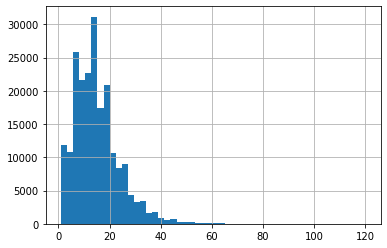

In [8]:
df.groupby("time")["cart"].count().hist(bins=50)
df.groupby("time")["cart"].count().describe()

### Формирование датасета

In [9]:
# Заменяет повторяющиеся товары в корзине на одну запись с указанием количества
def duplicates_to_count(t):
    return (
        t.groupby(['user_id', 'time'])['cart']
            .value_counts()
            .to_frame()
            .rename(columns={"cart":"count"})
            .reset_index()
    )

# Производит обратную операцию
def count_to_duplicates(t): 
    g = t.copy()
    g["to_explode"] = g["count"].apply(lambda x: [i for i in range(x)])
    g = g.explode("to_explode").drop(columns=["count", "to_explode"])
    return g

# Создает все комбинации user_id (пользователя) и cart (товара), которые пользователь когда-либо покупал
def make_skeleton(t):
    return t.groupby("user_id")["cart"].unique().to_frame().reset_index().explode("cart")

# Создает train датасет и ответы для него
# Ответы формируются на основе последней корзины каждого пользователя
# lvevel=1 означает, что для формирования ответов берётся последняя покупка, level=2 - предпоследняя и так далее 
def make_train_targets(t, level=1): 
    user_last_time = t.groupby(["user_id"])["time"].max().to_frame().reset_index()
    user_last_time["last_buy"] = 1
    
    train = pd.merge(t, user_last_time, on=["time", "user_id"], how="left")
    train = train[train["last_buy"] != 1]
    train.drop(columns=["last_buy"], inplace=True)
    
    if level >= 2:
        return make_train_targets(train, level-1)
    
    user_last_time.drop(columns=["last_buy"], inplace=True)
    
    user_last_carts = pd.merge(user_last_time, t, on=["user_id", "time"], how="left")
    
    skeleton = make_skeleton(t)
    targets = pd.merge(skeleton, user_last_carts.drop(columns=["time"]), on=["user_id","cart"], how="left")
    targets.fillna(0, inplace=True)
    targets["count"] = targets["count"].apply(lambda x: x if x <= 1 else 1).astype(int)
    targets.rename(columns={"count":"target"}, inplace=True)
    return train, targets

In [10]:
df = duplicates_to_count(df)

In [11]:
df.head()

,user_id,time,cart,count
0,0,2020-07-19 09:59:17,14,1
1,0,2020-07-19 09:59:17,20,1
2,0,2020-07-19 09:59:17,57,1
3,0,2020-07-19 09:59:17,82,1
4,0,2020-07-19 09:59:17,379,1


In [12]:
train, targets = make_train_targets(df, level=1)

In [13]:
train.head()

,user_id,time,cart,count
0,0,2020-07-19 09:59:17,14,1
1,0,2020-07-19 09:59:17,20,1
2,0,2020-07-19 09:59:17,57,1
3,0,2020-07-19 09:59:17,82,1
4,0,2020-07-19 09:59:17,379,1


In [14]:
targets.head()

,user_id,cart,target
0,0,14,0
1,0,20,0
2,0,57,1
3,0,82,0
4,0,379,0


## Подходы

### Последняя корзина пользователя
Возьмем последнюю корзину пользователя и порекомендуем все товары из неё в качестве следующей корзины

In [15]:
def user_last_cart_baseline(t, skeleton):
    user_last_time = t.groupby(["user_id"])["time"].max().to_frame().reset_index()
    user_last_carts = pd.merge(user_last_time, t, on=["user_id", "time"], how="left") 
    res = pd.merge(skeleton, user_last_carts.drop(columns=["time"]), on=["user_id","cart"], how="left")\
        .fillna(0).rename(columns={"count":"predict"})
    res["predict"] = res["predict"].progress_apply(lambda x: x if x <= 1 else 1).astype(int)
    return res

In [16]:
train_res = user_last_cart_baseline(train, targets)

  0%|          | 0/1117600 [00:00<?, ?it/s]

In [17]:
train_res.head()

,user_id,cart,target,predict
0,0,14,0,1
1,0,20,0,0
2,0,57,1,1
3,0,82,0,1
4,0,379,0,1


In [18]:
f1_score(train_res["target"], train_res["predict"])

0.3393176623703617

### Топ товаров для каждого пользователя

#### Фиксированный размер корзины

Возьмем все известные корзины пользователей, составим для каждого из них персональный топ продуктов фиксированного размера и порекомендуем его

In [19]:
def user_top_k_personal_rec_baseline(t, skeleton, k=10):
    g = (
        count_to_duplicates(t)
        .groupby("user_id")["cart"].value_counts()
        .to_frame().rename(columns={"cart":"count"})
        .groupby("user_id")["count"].head(k)
        .to_frame().reset_index()
        .drop(columns=["count"])
    )
    g['predict'] = 1
    res = skeleton.copy()
    res = res.merge(g, how='left', on=['user_id', 'cart'])
    res['predict'] = res['predict'].fillna(0).astype(int)
    
    return res

In [20]:
train_res = user_top_k_personal_rec_baseline(train, targets)

In [21]:
train_res.head()

,user_id,cart,target,predict
0,0,14,0,1
1,0,20,0,1
2,0,57,1,1
3,0,82,0,1
4,0,379,0,1


In [22]:
f1_score(train_res["target"], train_res["predict"])

0.34319546434025816

#### Нефиксированный размер корзины

Для ухода от фиксированного размера корзины для всех пользователей можно брать среднее или медианное количество товаров в корзине для каждого пользователя. Это дает серьезный прирост в качестве.

In [23]:
def user_top_x_personal_rec_baseline(t, skeleton):
    users_cart_len = (
        t.groupby(["user_id", "time"])["count"].sum()
        .reset_index()
        .groupby("user_id")["count"].median().round().astype(int)
        .reset_index()
        .rename(columns={"count": "cart_len"})
    )
    
    g = (
        count_to_duplicates(t)
            .groupby("user_id")["cart"]
            .value_counts()
            .to_frame()
            .rename(columns={"cart":"count"}).reset_index()
        )
    g = pd.merge(g, users_cart_len, on='user_id', how='left')
    
    g = (
        g.groupby("user_id").progress_apply(lambda x: x["cart"][:x["cart_len"].unique()[0]])
        .to_frame().droplevel(level=1).reset_index()
    )
    
    g['predict'] = 1
    res = skeleton.copy()
    res = res.merge(g, how='left', on=['user_id', 'cart'])
    res['predict'] = res['predict'].fillna(0).astype(int)
    
    return res

In [24]:
train_res = user_top_x_personal_rec_baseline(train, targets)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [25]:
f1_score(train_res["target"], train_res["predict"])

0.38992994994398833

### Tоп популярных товаров

#### Фиксированный размер корзины

Возьмем все известные корзины пользователей, составим общий топ самых популярных товаров и порекомендуем его

In [26]:
def top_k_popular_baseline(t, skeleton, k=15):
    top_k_items = t.groupby("cart")["count"].sum().to_frame().reset_index() \
                   .sort_values("count", ascending=False).head(k)["cart"].tolist()
    
    res = skeleton.copy()
    res['predict'] = np.where(res.cart.isin(top_k_items), 1, 0)
    
    return res

In [27]:
train_res = top_k_popular_baseline(train, targets)

In [28]:
f1_score(train_res["target"], train_res["predict"])

0.36758787992167213

#### Нефиксированный размер корзины

Здесь так же можно использовать нефиксированную длину рекомендуемой корзины

In [29]:
def top_x_popular_baseline(t, skeleton):
    
    users_cart_len = (
        train.groupby(["user_id", "time"])["count"].sum()
        .reset_index()
        .groupby("user_id")["count"].median().round().astype(int)
        .reset_index()
        .rename(columns={"count": "cart_len"})
    )
    
    top_x_max_items = t.groupby("cart")["count"].sum().to_frame().reset_index() \
                   .sort_values("count", ascending=False)["cart"].tolist()[:users_cart_len["cart_len"].max()]
    
    users_cart_len["cart"] = users_cart_len["cart_len"].apply(lambda x: top_x_max_items[:x])
    users_top_x = users_cart_len.drop(columns=["cart_len"]).explode("cart")
    users_top_x["predict"] = 1
    
    res = skeleton.copy()
    res = res.merge(users_top_x, how='left', on=['user_id', 'cart'])
    res['predict'] = res['predict'].fillna(0).astype(int)
    
    return res

In [30]:
train_res = top_x_popular_baseline(train, targets)

In [31]:
f1_score(train_res["target"], train_res["predict"])

0.37505094485043405